# DS 675-851 Mini Project -- Animals-10 Dataset

#### Contents of this notebook by Kevin Kaplan

## Introduction

### Dataset

The dataset selected for this project was the Animals-10 dataset on Kaggle. It contains 26179 images, each belonging to one of ten classes.  The classes are as follows: dog, cat, horse, butterfly, squirrel, chicken, sheep, cow, elephant, and spider. The files are downloaded in a folder which contains a unique folder for each class' images.  There is a slight class imbalance with this dataset, but it is robust enough that it should not have a major impact on the results. 

Link to dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

### Learning Objective and Summary

Our main objective in this mini project was to classify images of the Animals-10 dataset.  To execute that task, we created Convolutional Neural Networks.  Several homemade CNNs were trained and tested.  For each model the results were analyzed, and then altered in an attempt to get better results. From there several CNN interpreative methods were used to gain deeper insights into the model, and ultimatley refine the model with those insights. Additionally, pretrained CNNs such as VGG-16 and others will be tested and analyzed with the same methods, and then ensembled to test results.

## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from proj_utils import *

## Data

To prepare the data for use, each file's image path and label is first loaded into a dataframe.  The data is visualized by entries per class. It is then split into train, test, and validation sets.  An ImageDataGenerator is used for data augmentation and preprocessing for training.  Some examples of the augmentations used are random height and width shifts, flips along both axes, etc.  Then the datagenerators for each set are prepared.

### Load Data

In [3]:
# filepath
path = "/Users/kevinkaplan/Desktop/cs675_project/archive/raw-img"
# load data to df
df = get_file_df(path)

### Visualize Data

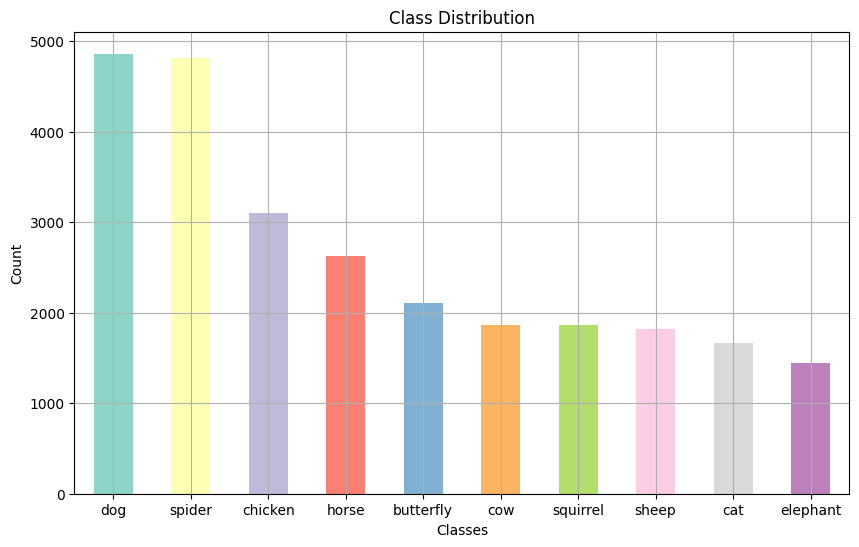

In [4]:
# get count per class
class_counts = df['label'].value_counts()

# show graph
class_counts_graph(class_counts)

We can see there is a slight class imbalance in the data here. It shouldn't provide too much of an issue, but nevertheless we try different methods to mitigate this.  

### Prepare Data

#### Split Data

In [17]:
from sklearn.model_selection import train_test_split
# ratio for sets
train_ratio = 0.6  
validation_ratio = 0.2  
test_ratio = 0.2  

# initial split
train_data, test_data = train_test_split(df, test_size=test_ratio, random_state=13, stratify=df['label'])

# validation split
train_data, validation_data = train_test_split(train_data, test_size=validation_ratio, random_state=13, stratify=train_data['label'])

# display sizes 
print("Training set size:", len(train_data))
print("Validation set size:", len(validation_data))
print("Test set size:", len(test_data))

Training set size: 16754
Validation set size: 4189
Test set size: 5236


#### Setup the Data Generators

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# define image and batch sizes
image_size = (224, 224)
batch_size = 64

# ImageDataGenerator, apply various data augmentations
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  
    rotation_range=20,  
    width_shift_range=0.20,  
    height_shift_range=0.20,  
    horizontal_flip=True,  
    vertical_flip=True
)

# training data
train_datagen = datagen.flow_from_dataframe(
    dataframe=train_data,  
    directory=None,  
    x_col='image_path',  
    y_col='label',  
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
)

# validation data
validation_datagen = datagen.flow_from_dataframe(
    dataframe=validation_data,  
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# test data
test_datagen = datagen.flow_from_dataframe(
    dataframe=test_data,  
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 16754 validated image filenames belonging to 10 classes.
Found 4189 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


### Remarks

The data is now ready to be used with CNN. Regarding the class imbalance-- there are many methods to try to combat this, such as class weighting, oversampling, and several others.  Some methods will be tried, but this is a potential  area for improvement of the model in the future.

## Homemade CNN

### Model Construction

For this project fourteen models were initially trained, making adjustments and tuning hyperparameters in an attempt to get a better model. Shown below is the construction of the first model before any modifications were made.  The model is then loaded from the saved file and analyzed as it would take too long to retrain the model in the notebook (avg train time ~5.5 hrs).  The tuning and modification of the model, and results will be discussed in detail at the end of the section.

#### Code for Model Construction

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import regularizers

# set num_epochs
num_epochs = 200

In [20]:
# define model

# num classes in train
num_classes = len(train_data['label'].unique())

# set reg param
# lambda_l2 = 0.001

# create CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu', strides=2))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(layers.Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(layers.Dense(num_classes, activation='softmax'))


### Train Model Code

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import subprocess

# run the caffeinate command in the background to prevent system sleep
caffeinate_process = subprocess.Popen(['caffeinate'])


# compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# earlystopping params
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=20,         
    verbose=1,           
    restore_best_weights=True  
)

# train
history = model.fit(
    train_datagen,
    validation_data=validation_datagen,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    # class weights can be included here
    # class_weight=class_weight_dict
)

# save model
model.save('kxx.h5')

# eval with test
test_loss, test_accuracy = model.evaluate(test_datagen)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# end caffeinate 
caffeinate_process.terminate()

### Performance/Analysis

#### Code

In [21]:
# load model
model = tf.keras.models.load_model('k1.h5')

In [ ]:
# performance
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# get predictions
predictions = model.predict(test_datagen, verbose=1)

# ytrue/ypred
y_true = test_datagen.classes
y_pred = np.argmax(predictions, axis=1)

# calc metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

#### Results

In [23]:
# display results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Accuracy: 0.7488540870893812
Precision: 0.7526712058084805
F1 Score: 0.7478009328361234
Recall: 0.7488540870893812


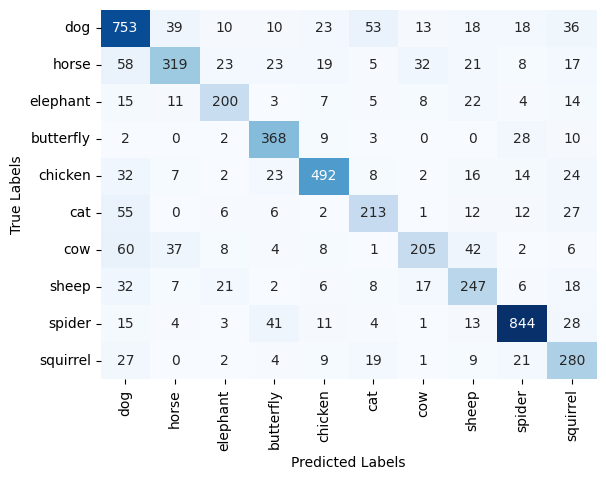

In [24]:
# confusion matrix

disp_cm(test_datagen, y_true, y_pred)

As a starting point, we have a pretty decent model.  There is certainly room for improvement though, and that is what we are going to do. We can begin to see from the confusion matrix some areas the model is struggling with.  It is overpredicting and overclassifying the largest class, dog.  There is also a lot of confusion between most of the classes of the larger mammals, as well as confusion between the insect classes.  Additionally, there is a decent amount of confusion between chicken and butterfly as well.  It is possible this is from the wings.  Overall, it seems like we may want to try methods for class imbalance as well as attempting to capture different features, and hopefully nudge the model into a more productive direction.

### All Models

##### Load Models and Get Predictions Code

In [26]:
mod_1 = tf.keras.models.load_model('k1.h5')
mod_2 = tf.keras.models.load_model('k2.h5')
mod_3 = tf.keras.models.load_model('k3.h5')
mod_4 = tf.keras.models.load_model('k4.h5')
mod_5 = tf.keras.models.load_model('k5.h5')
mod_6 = tf.keras.models.load_model('k6.h5')
mod_7 = tf.keras.models.load_model('k7.h5')
mod_8 = tf.keras.models.load_model('k8.h5')
mod_9 = tf.keras.models.load_model('k9.h5')
mod_10 = tf.keras.models.load_model('k10.h5')
mod_11 = tf.keras.models.load_model('k11.h5')
mod_12 = tf.keras.models.load_model('k12.h5')
mod_13 = tf.keras.models.load_model('k13.h5')
mod_14 = tf.keras.models.load_model('k14.h5')

In [27]:
models =[mod_1, mod_2, mod_3, mod_4, mod_5, mod_6, mod_7, mod_8, mod_9, mod_10, mod_11, mod_12, mod_13, mod_14]

In [37]:
results = []

y_true = test_datagen.classes
preds = []
for i, model in enumerate(models):
    pred = model.predict(test_datagen, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    preds.append(pred)
    
    # calc metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # add to results
    results.append({
        "Model": f"Model {i + 1}",
        "Accuracy": accuracy,
        "Precision": precision,
        "F1 Score": f1,
        "Recall": recall
    })

# Create a DataFrame to display results as a table
results_df = pd.DataFrame(results)


##### Results

In [38]:
# results
print(results_df)

       Model  Accuracy  Precision  F1 Score    Recall
0    Model 1  0.741406   0.744405  0.740308  0.741406
1    Model 2  0.758594   0.767435  0.758835  0.758594
2    Model 3  0.733766   0.753361  0.731221  0.733766
3    Model 4  0.713331   0.734819  0.714899  0.713331
4    Model 5  0.728992   0.739722  0.730808  0.728992
5    Model 6  0.735676   0.751400  0.734740  0.735676
6    Model 7  0.803858   0.807871  0.803629  0.803858
7    Model 8  0.735294   0.750443  0.732624  0.735294
8    Model 9  0.732047   0.741438  0.730629  0.732047
9   Model 10  0.799465   0.801255  0.797968  0.799465
10  Model 11  0.809206   0.815901  0.809119  0.809206
11  Model 12  0.806914   0.816320  0.808881  0.806914
12  Model 13  0.750764   0.761182  0.749832  0.750764
13  Model 14  0.790107   0.793305  0.788868  0.790107


In the above output, each iteration of the model is shown, along with its performance metrics.  Other starting points were tested, but are not included in the table shown due to poor performance.  Many changes were made in an attempt to improve the original model. The use of class weights were implemented at a few different iterations, but interestingly, yeilded minimal or no improvement.  When examining the confusion matrix for a model with and without class weights (shown below), we can see that it is no longer overpredicting the largest class (dog), but it just leads to more misclassifications of that class. Additionally, it is now overpredicting the second largest class more than without weights (spider).  This could be improved upon potentially by trying different weights possibly, however, the model without weights was proceeded with.

Without Class Weights:


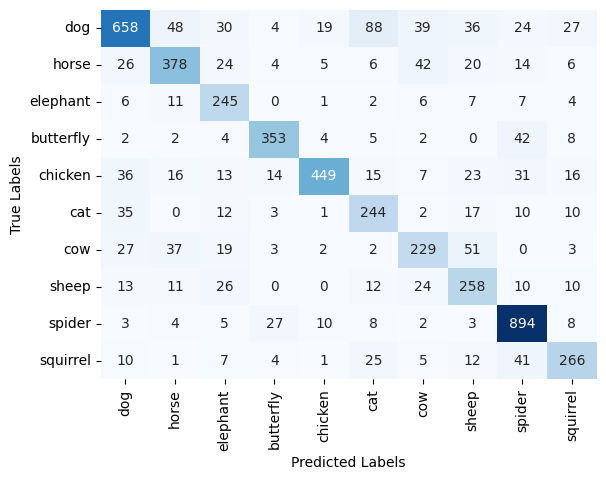


With Class Weights:


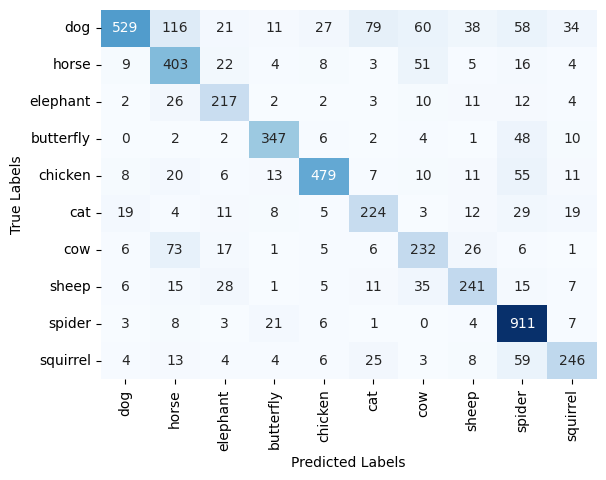

In [41]:
# example cm before class weights
print("Without Class Weights:")
disp_cm_model(test_datagen, mod_2)
print()
print("With Class Weights:")
disp_cm_model(test_datagen, mod_3)

In addition to class weights, different activations were tested, including leaky relu.  It did not seem to help, so the original and more common relu activation was kept for the remaining iterations. The batch size was both halved and doubled, and neither led to any improvement.  The batch size of 64 for used for the rest of the models.

To help improve the training of the model, batch normalization was used.  Batch normalization can also help a bit with generalization and overfitting by providing a regularization affect. However, through various iterations, it was evident that there was still some overfitting occuring when analyzing the loss curves for the train and validation data.  To help mitigate this, various regularization methods were employed.  L1 and L2 regularization were used, however they did not provide much help, or increased the computational cost too greatly to be a viable option.  The one regularization method that did seem to have good results was including dropout layers.  The dropout layers regularize by randomly deactivating a portion of the neurons at each step. 

Additional impactful changes were increasing the number of filters and changing strides of the convolutional layer.  By adding more filters and using different strides, the goal was to try to capture more and different features of the images.  Adding and removing an additional dense layers, as well as the number of neurons in those layers were experimented with as well. However, finding a balance of these hyperparameters and architectures began to become a guessing game.  Aside from finding a balance between having too many filters (causing overfitting), different layers, what strides to use, how many dropouts, where to put them, and what fraction to use, computation cost is another major consideration.  On top of that, to this point, while alot has been done it is only scratching the surface of possible options to try. From here it is becoming even more clear that it would be invaluable to be able to have more information to make better decisions in tuning the model.

We can see from the results of the model training and tuning that while improvements were made, at a certain point it becomes more of a guessing game with the available information.  Couple that with the fact that each model took an average of five and a half hours to train, and one misstep in tuning the model can easily cost you the better part of the day.  This drives home the importance of informed decision making in tuning the model, and raises the question-- what can we do to improve our decision making?

After previous experience studying interpretable machine learning methods, I became interested in Grad-CAM and similar methods. These methods work to enable us to visualize what the model 'sees' when making a decision, giving us more insight to what the model is doing and how it is making predictions.  From here, we can leverage these methods for a deeper understanding of our model, and hopefully make more informed decisions when modifying the model.

### Analyzing the Best Model

Model 11 appears to be our best model, and here we will analyze it further:

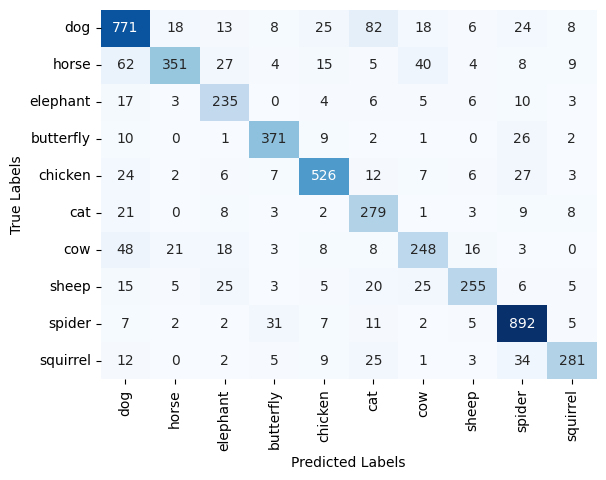

In [42]:
disp_cm_model(test_datagen, mod_11)

Aside from the model overpredicting for the largest class, there are many insights we can gain from the confusion matrix. Similarly to our original model, there is also a lot of confusion between most of the classes of the larger mammals, as well as confusion between the insect classes.  Some of the areas where the previous model had alot of confusion have been improved upon, like butterfly and chicken and the mammals in general.  There are still some areas where the model is specifically struggling, like cat and dog or horse and cow.  The insect classes are still being confused as well. Overall, it still seems like we may want to try methods for class imbalance as well as attempting to capture different features, and hopefully nudge the model into a more productive direction.  Next we will look into some of these misclassifications in more depth.

## Interperatablility Methods

Interpretability methods for CNNs give us insights on how they make decisions.  They provide visualizations enabling us to 'see' what the CNN sees when making its predictions-- shedding some light into the 'black box.' There are many different methods for interpreting CNNs, including pertubation based methods like occlusion sensitivity or LIME ImageExplainer. There are activation based methods like activation maximization and intermediate activations as well.  In this project, the focus was on gradient based methods.  The gradient based methods used in this project include Vanilla and SmoothGrad Saliency Maps, Grad-CAM, Grad-CAM++, and Path Integrated Gradients.

While all of these methods will give us a deeper understanding of how the model is making decisions and further insights into how the images are being classified, the objective is to use information gained from these methods to help guide decisions on improving the model.  By taking intuitions and insights gained from the original analysis of the models performance, the interpretation methods can help us look further into them.  Specific misclassifications and classes can be looked at, hopefully enabling us to see key features the model is focusing on and ultimatley identifying weaknesses in the model.  

Using this information, modifications to the model and data can be made accordingly.  Now instead of being at a point of guessing, we can hopefully make a more informed decision on what to do.  In this notebook, the focus is on confusion between dog and cat as it is the most significant confusion we saw in the previous section. The demonstration is for showing these specific misclassified images, however the code can be used to analyze any portion of the data desired.

### Gradient Based Attribution Methods

Gradient based methods calculate attribution maps for each datapoint through forward and backward passes through the network.  To calculate the attribution maps, the gradients in the backward pass are used.  We can then use the results to visualize how much each input feature contributes to the models prediction.  Saliency Maps, both Vanilla & SmoothGrad, Grad-CAM, Grad-CAM++, and Path Integrated Gradients are all used in this section.  Each method provides us with a different way of visualizing and understanding the model's predictions.  This will provide us with valuable insights into which parts of the data are key to the model's decisions. For each of the models, a single example will be shown, and finally with Grad-CAM++, several misclassifications will be analyzed.

#### Setup Code

First, we must prepare the data for use with these methods, as well as load in our best performing model to analyze.

In [43]:
# load model
model = mod_11

# evaluate model
pred = model.predict(test_datagen, verbose=1)
y_pred = np.argmax(pred, axis=1)

82/82 [==============================] - 32s 389ms/step


In [44]:
class_ind = test_datagen.class_indices
indices = {v: k for k, v in {translate[key]: value for key, value in class_ind.items() if key in translate}.items()}
files = test_datagen.filenames
print(indices)

{0: 'dog', 1: 'horse', 2: 'elephant', 3: 'butterfly', 4: 'chicken', 5: 'cat', 6: 'cow', 7: 'sheep', 8: 'spider', 9: 'squirrel'}


In [45]:
y_true = test_datagen.classes

In [46]:
# used modified code from what do cnns see
test_df = pd.DataFrame()
test_df['file'] = files
test_df['actual'] = y_true
test_df['predicted'] = y_pred
test_df['actual'] = test_df['actual'].apply(lambda x: indices[x])
test_df['predicted'] = test_df['predicted'].apply(lambda x: indices[x])
test_df['predictions'] = pred.tolist()
test_df.head(10)

file    actual predicted  \
0  /Users/kevinkaplan/Desktop/cs675_project/archi...  squirrel  squirrel   
1  /Users/kevinkaplan/Desktop/cs675_project/archi...  squirrel  squirrel   
2  /Users/kevinkaplan/Desktop/cs675_project/archi...    spider    spider   
3  /Users/kevinkaplan/Desktop/cs675_project/archi...       dog       dog   
4  /Users/kevinkaplan/Desktop/cs675_project/archi...       dog       cat   
5  /Users/kevinkaplan/Desktop/cs675_project/archi...       dog       dog   
6  /Users/kevinkaplan/Desktop/cs675_project/archi...     horse     horse   
7  /Users/kevinkaplan/Desktop/cs675_project/archi...       dog       cat   
8  /Users/kevinkaplan/Desktop/cs675_project/archi...    spider    spider   
9  /Users/kevinkaplan/Desktop/cs675_project/archi...   chicken   chicken   

                                         predictions  
0  [0.058125294744968414, 7.122429087758064e-05, ...  
1  [0.01698034629225731, 0.0010258849943056703, 0...  
2  [0.0011486487928777933, 0.00025567651027813554...  
3  [0.975271463394165, 0.0001260948192793876, 3.2...  
4  [0.36657747626304626, 5.744340887758881e-05, 5...  
5  [0.9105271100997925, 0.0010551799787208438, 6....  
6  [0.048081014305353165, 0.7717127799987793, 0.0...  
7  [0.10646572709083557, 0.010662151500582695, 0....  
8  [0.0005650794482789934, 6.252320599742234e-05,...  
9  [6.670377842965536e-06, 3.6674740044873033e-07...

In [47]:
# some misclassifications of potential interest/examples

mc_cow_as_horse = test_df[(test_df['actual'] == 'cow') & (test_df['predicted'] == 'horse')]
mc_cow_as_dog = test_df[(test_df['actual'] == 'cow') & (test_df['predicted'] == 'dog')]
mc_dog_as_cat = test_df[(test_df['actual'] == 'dog') & (test_df['predicted'] == 'cat')]
mc_cat_as_dog = test_df[(test_df['actual'] == 'cat') & (test_df['predicted'] == 'dog')]
mc_spider_as_bf = test_df[(test_df['actual'] == 'spider') & (test_df['predicted'] == 'butterfly')]
mc_bf_as_spider = test_df[(test_df['actual'] == 'butterfly') & (test_df['predicted'] == 'spider')]
mc_as_dog = test_df[(test_df['predicted'] == 'dog') & (test_df['actual'] != 'dog')]

In [48]:
from sklearn import preprocessing
# source text book

y_train = train_datagen.classes
y_train = np.reshape(y_train, (-1, 1))

enc = preprocessing.OrdinalEncoder()
enc.fit(y_train)
y_pred_exp = np.expand_dims(np.array(y_pred),axis=1)
y_pred_enc = enc.transform(y_pred_exp)
labels_l = y_pred_enc[mc_dog_as_cat.index.tolist()].squeeze().astype(int).tolist()

In [49]:
# get X, preprocessed images
X = process_images(mc_dog_as_cat)

In [50]:
# define function for use with interp methods, gives losses for classes we are interested in
def loss(output):
    global labels_l
    pos_l = [*range(len(labels_l))]
    output_l = []
    for p, l in zip(pos_l, labels_l):
        output_l.append(output[p][l])
    return tuple(output_l)
    # credit to interp ml text

#### Saliency Maps

##### Saliency Maps Intro

Saliency maps highlight critical reigons of input, relying on gradients to determine which pixels impact the models predictions most significantly. The original method, 'Vanilla' Saliency Maps, rely on the absolute value of the gradients. It attempts to find the pixels that can be perturbed the least to result in an output that changes the most.  However, it doesnt conduct the pertubations and can't validate it due to the use of the absolute values.  SmoothGrad on the other hand, creates small pertubations which introduce noise to the image, calculates the gradients of them, and then averages the results to give a 'smooth' resulting saliency map.  Here both methods are shown.

##### Saliency Maps Code

In [18]:
from tf_keras_vis.saliency import Saliency

In [51]:
# create saliency obj
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

# saliency maps
saliency_maps = saliency(loss, X)

# sg maps
smoothgrad_saliency_maps = saliency(loss, X, smooth_samples=20, smooth_noise=0.20)

##### Saliency Maps Results

/var/folders/fk/pn9tnd6n0_gfl83thppbs9w40000gn/T/ipykernel_55476/1265861147.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


Text(0.5, 1.0, 'SmoothGrad Saliency Map')

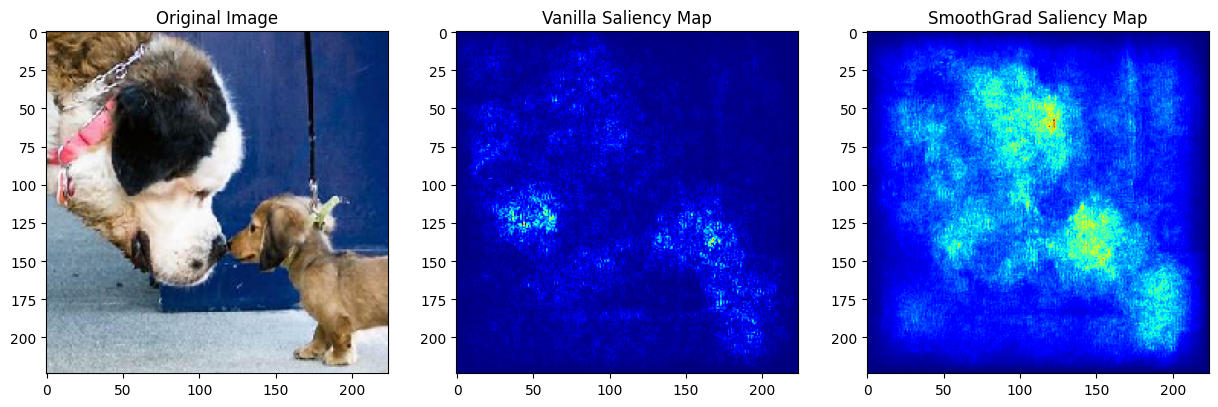

In [55]:
# Display Results

plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(X[11])
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(saliency_maps[11], cmap='jet')
plt.title("Vanilla Saliency Map")
plt.subplot(1, 3, 3)
plt.imshow(smoothgrad_saliency_maps[11], cmap='jet')
plt.title("SmoothGrad Saliency Map")

##### Interpretation

We can see from the maps here that while the model is not focusing on entirely irrelevant features, we still may need to capture more complexities to gain improvement in our model. 

#### Grad CAM

##### GradCAM Intro

Class Activation Maps (CAM) work by removing everything exept for the last dense layers and replaces the MaxPooling layer with a Global Average Pooling layer. The idea is that the spatial details in a CNN are lost in the fully connected layers.  When the last convolutional layer is weighted, the filters represent the most salient reigons of the image.  CAM is difficult to implement, so Grad-CAM uses gradients to get neuron importance weights.  Activation maps are then produced, and can be visualized for us to interpret.  While Grad-CAM is an improvement over CAM, it does have some issues.  It can fail in certain circumstances, and Grad-CAM++ was developed to improve upon this.

##### Grad CAM Code

In [56]:
from tf_keras_vis.gradcam import Gradcam

In [57]:
# create fradcam object
gradcam = Gradcam(model,
                  model_modifier=ReplaceToLinear(),
                  clone=True)

# generate maps
gradcam = gradcam(loss,
              X,
              penultimate_layer=-1)


##### Grad CAM Results

/var/folders/fk/pn9tnd6n0_gfl83thppbs9w40000gn/T/ipykernel_55476/1010980787.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


Text(0.5, 1.0, 'Overlayed')

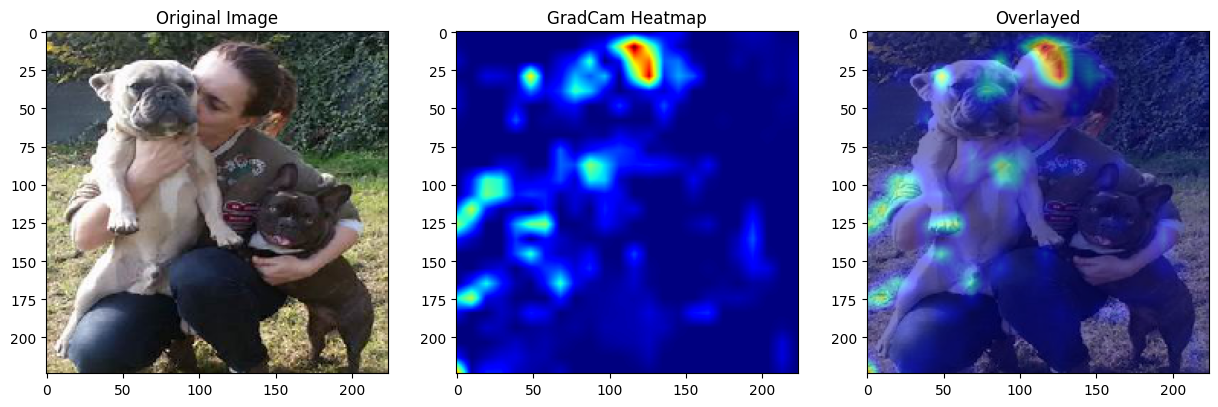

In [60]:
# display results

plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(X[15])
plt.title("Original Image")

plt.subplot(1, 3, 2)
heatmap = np.uint8(cm.jet(gradcam[15])[..., :3] * 255)
plt.imshow(heatmap)
plt.title("GradCam Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(X[15])
plt.imshow(heatmap, alpha=0.5)
plt.title("Overlayed")

##### Interpretation

Here it looks like the background and person in the image may be confusing the model.  The model is picking up certain features on the dog, however most heavily focuses on the womans hairline, and some other irrelevant features.  Providing different data augmentation and attempting to capture more complex features can help to mitigate this.

#### Integrated Gradients

##### Integrated Gradients Intro

Integrated Gradients, or Path Integrated Gradients, work to calculate feature importance through the use of the integral of the gradients along paths connecting a baseline to the input image. The baseline is an all black image in our case, as the image pixels are all set to 0. It progressivley gets to the basleine image through a number of steps, puts all of these images through the CNN, computes the gradient, and then averages it.  The integrated gradient is then calculated-- it is the dot product of the image and the average gradients.  We can use the results to further confirm hypotheses from analyzing the model results.

##### Integrated Gradients Code

In [61]:
from tf_explain.core.integrated_gradients import IntegratedGradients

In [62]:
explainer = IntegratedGradients()
ig_heatmaps = []

for i in range(len(labels_l)):
    image = ([X[i]], None)
    label = labels_l[i]
    ig_heatmap = explainer.explain(image, model, label, n_steps=25)
    ig_heatmaps.append(ig_heatmap)

2023-12-06 14:26:29.752905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-06 14:26:29.965657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


##### Integrated Gradients Results

/var/folders/fk/pn9tnd6n0_gfl83thppbs9w40000gn/T/ipykernel_55476/1619489480.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


Text(0.5, 1.0, 'Integrated Gradients Overlayed')

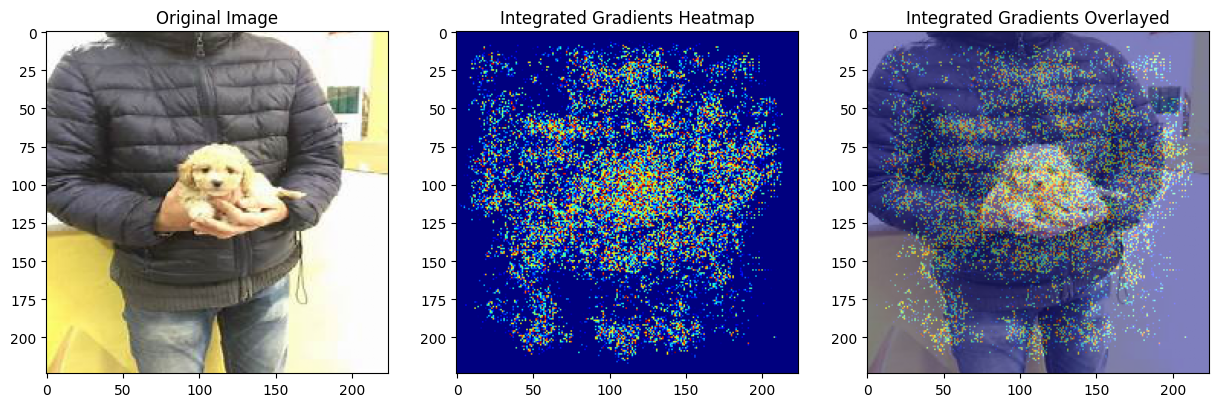

In [63]:
# display results

plt.subplots(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(X[7])

plt.title("Original Image")
plt.subplot(1, 3, 2)
heatmap = np.uint8(cm.jet(ig_heatmaps[7])[..., :3] * 255)
plt.imshow(heatmap)

plt.title("Integrated Gradients Heatmap")
plt.subplot(1, 3, 3)
plt.imshow(X[7])
plt.imshow(heatmap, alpha=0.5)

plt.title("Integrated Gradients Overlayed")

##### Interpretation

Again, the model is not focusing on relevant features and is confused by the background of the image.

#### Grad CAM++

##### GradCAM++ Intro

Grad-CAM++ is an improved version of Grad-CAM, addressing the issues that Grad-CAM has.  Here we can see how this version does infact provide a better representation of the data.

##### Grad CAM++ Code

In [65]:
def get_gc_map(df):
    # indexes of misclassifications/categories of interest
    # CATEGORICAL_INDEX = df.index.tolist()

    # make gc++ object
    gc = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)

    # get X, preprocessed images
    X = process_images(df)

    # generate heatmap
    gc_maps = gc(loss, X, penultimate_layer=-1)

    # docs say normalize not necessary v0.6.0 -- using 0.8.6
    # gc_maps = normalize(gc_maps)

    return gc_maps

In [66]:
gc_map = get_gc_map(mc_dog_as_cat)

##### Grad CAM++ Results

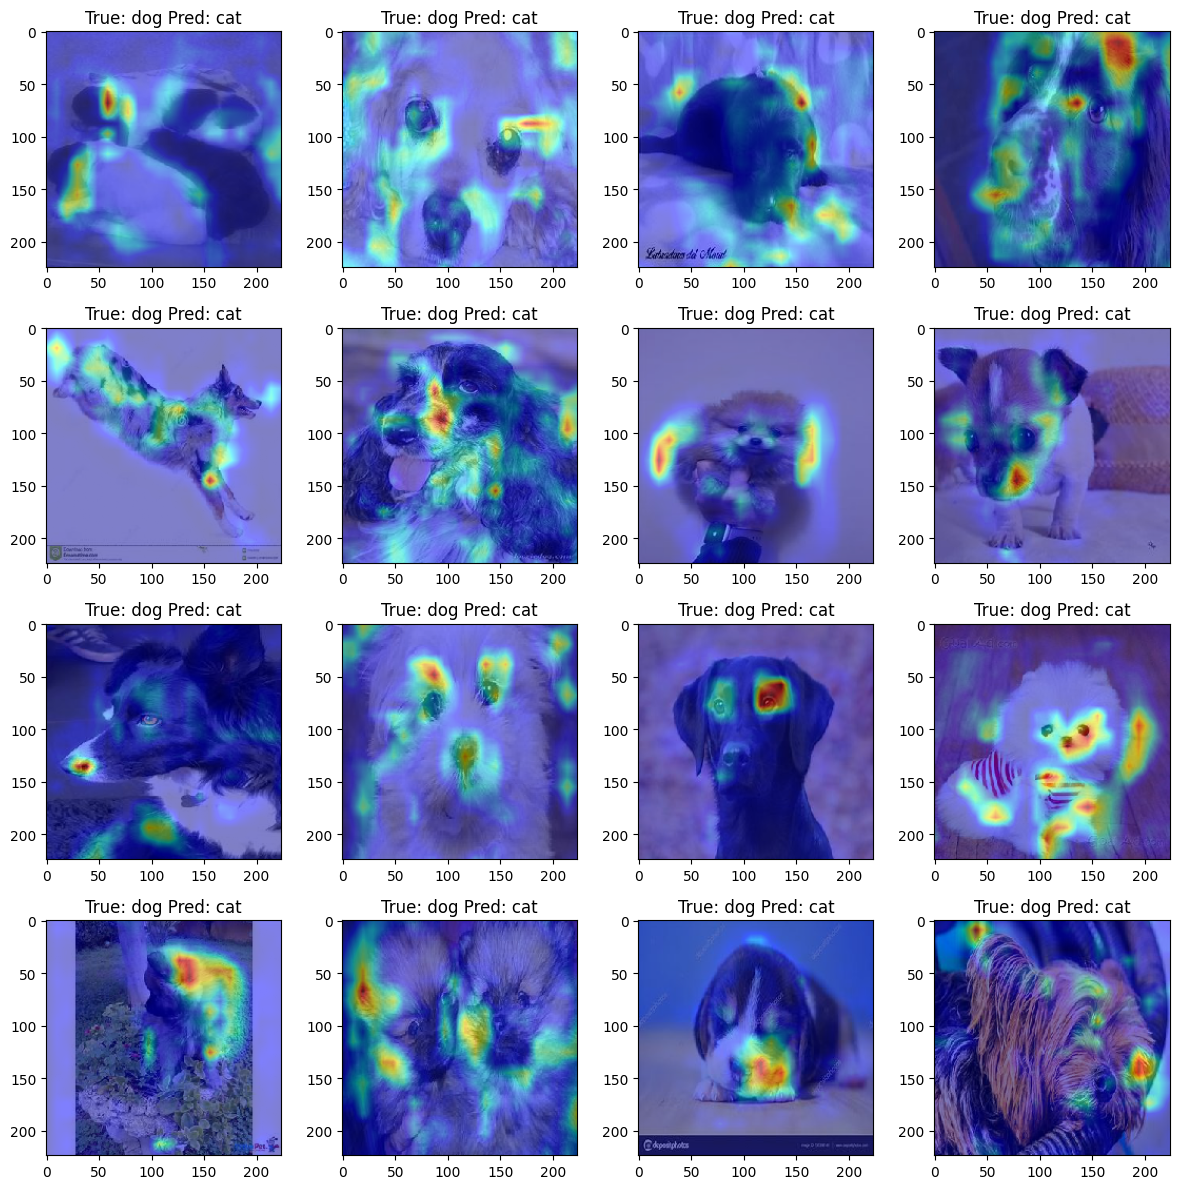

In [70]:
num_images = 16
images_per_row = 4
num_rows = -(-num_images // images_per_row)  

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(12, 3 * num_rows))
mc_df = mc_dog_as_cat.reset_index(drop=True)

for i in range(num_images):
    # row and col idx
    row = i // images_per_row  
    col = i % images_per_row  
    # incase single row (remainder)
    ax = axes[row, col] if num_rows > 1 else axes[col]  
    
    # show original img
    ax.imshow(X[i + 35])  
    
    # get heatmap and overlay
    heatmap = np.uint8(cm.jet(gc_map[i + 35])[..., :3] * 255)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)  
    #ax.axis('off') 

    # set title to show actual and predicted classes
    ax.set_title(f'True: {mc_df.actual[i + 35]} Pred: {mc_df.predicted[i + 35]}')  

# show w/ no overlap
plt.tight_layout()
plt.show()

##### Interpretation

We can see the model is highlighting some irrelevant features in these cases, however it is focusing on the face eyes and fur of the dogs as distinguishing features.  We can aim to improve the model to help it identify finer distictions between these classes through different methods.

## Modifying Model with New Insights

### Implement Changes

Through the analysis of the results, it is evident there are a few things to focus on.  we need to get the model to focus on finer distinguishing features, eliminating or reducing confusion between classes, and try to get the model to stop focusing on irrelevant features and/or the background. This can be addressed in two ways initially.  The first is to use more and more aggressive data augmentation techniques.  This will provide the model with more diverse data to learn from.  Hopefully allowing it to focus on the more important and generalized features and ignoring irrelevant ones that won't remain across the augmentations.  While I was initially more cautious with this, trying to mitigate the chances of introducing bad data that would negativley impact learning, based on observations of the model this should help performance and address the issues of the model focusing on irrelevant features in certain cases like we observed in the previous section.  Next, based on our observations, it seems the model is largley focusing on important areas of classification, but perhaps not picking up the finer details and nuances that distinguish these features.  To address this, we can augment the model to capture more features.  We need to be careful to not overfit it or create a model that is computationally unrealistic. First, three models were trained with that in mind. The results are displayed below.

#### Code

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# define image and batch sizes
image_size = (224, 224)
batch_size = 64

# ImageDataGenerator, apply various data augmentations
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  
    rotation_range=25,  
    width_shift_range=0.25,  
    height_shift_range=0.25,  
    zoom_range=0.2,  
    brightness_range=[0.8, 1.2],  
    shear_range=0.2,  
    horizontal_flip=True, 
    vertical_flip=True
)

# training data
train_datagen = datagen.flow_from_dataframe(
    dataframe=train_data,  
    directory=None,  
    x_col='image_path',  
    y_col='label',  
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
)

# validation data
validation_datagen = datagen.flow_from_dataframe(
    dataframe=validation_data,  
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# test data
test_datagen = datagen.flow_from_dataframe(
    dataframe=test_data,  
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 16754 validated image filenames belonging to 10 classes.
Found 4189 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [72]:
# model results

mod_15 = tf.keras.models.load_model('k15.h5')
mod_16 = tf.keras.models.load_model('k16.h5')
mod_17 = tf.keras.models.load_model('k17.h5')
mod_18 = tf.keras.models.load_model('k18.h5')
mod_19 = tf.keras.models.load_model('k19.h5')
mod_20 = tf.keras.models.load_model('k20.h5')

In [73]:
models = [mod_15, mod_16, mod_17, mod_18, mod_19, mod_20]

In [79]:
results = []

y_true = test_datagen.classes
preds = []
for i, model in enumerate(models):
    pred = model.predict(test_datagen, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    preds.append(pred)
    
    # calc metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # add to results
    results.append({
        "Model": f"Model {i + 15}",
        "Accuracy": accuracy,
        "Precision": precision,
        "F1 Score": f1,
        "Recall": recall
    })

# Create a DataFrame to display results as a table
results_df = pd.DataFrame(results)

#### Results

In [80]:
print(results_df)

      Model  Accuracy  Precision  F1 Score    Recall
0  Model 15  0.784759   0.809150  0.789521  0.784759
1  Model 16  0.811306   0.815792  0.809882  0.811306
2  Model 17  0.798510   0.805131  0.800051  0.798510
3  Model 18  0.802712   0.802379  0.801421  0.802712
4  Model 19  0.816272   0.819758  0.816800  0.816272
5  Model 20  0.843583   0.846173  0.843230  0.843583


While we land on one model that is out performing our previous models (model 16), the others did not improve and were showing signs of overfitting (by examining loss curves).  Next, the model is altered in an attempt to focus on capturing more complex features, while still maintaining good overall performance. Additional convolutional layers were added, and the final dense layers were increased (model 19).  All of the layers include batch normalization before the ReLU activation.  Two dropout layers are used as well.  To improve upon model 19, one of the dense layers were removed to help the model be more generalized and reduce potential for overfitting. The model summary is shown below. 

In [81]:
mod_20.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

### Analyze again

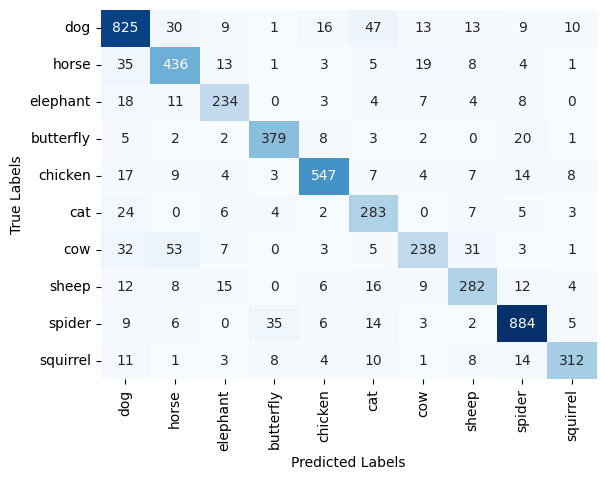

In [81]:
# repeat analysis methods
disp_cm_model(test_datagen, mod_20)

Here we see the confusion matrix for model 20, the top perfoming model. Aside from the general improvement of the model, we have acheived our goal of reducing the confusion between dog and cat, as well as reducing confusion between other classes.  We are starting to see some of the other confusions decrease or go away all together as well.  However there are still areas that could require attention.

While we were able to gain improvements, and do so more efficently, this process could be repeated and continued for better model performance.  In addition to these methods, we can try different data augmentation techniques and continue to make informed decisions on improving the model.  There are many other things we can do from here to improve performance as well.  One such example would be to ensemble models together in order to get a more diversified set of predictions.  This could lead to better generalization, and a better performing model  overall.

## Ensembling

### Pretrained Models

#### Grad-CAM Analysis

#### Create Ensemble

### Results

## Traditional ML Methods

Additionally, data was prepared for and trained using traditional machine learning methods with the goal of comparison to the more modern and widley used CNNs for image classification used in this project.  The two methods tested were Support Vector Machines and Random Forest. In order to prepare the data for training, it was first loaded into a dataframe, then split into train and test sets.  The pixel values were then normalized, preparing it for feature extraction to use in the models.  To extract features, custom Gabor Filters were used.  Several other filters were attempted as well, but the cost of running it was too great.  The dataset was modified to use just a quarter of the data, and the filters were modified to use just a few iterations of the Gabor Filters.  The other methods were eliminated.  Still, with less data and significantly less features to extract, the compute time was still quite long.  First, SVMs were trained. A GridSearchCV and RandomSearchCV were attempted to find optimal hyperparameters, however this process took an infeasible amount of time to run, and so a single SVM was trained.  The time it took to prepare the data, train, and test a single SVM on a fraction of the dataset was nearly three times that of the average training time of the homemade CNNs from this project.  After testing, the final results of the SVM gave an accuracy of 34% on the test data. The same methods were used to train a Random Forest model.  While the train and test times for Random Forest were significantly lower than SVM, they were still considerably long. The final accuracy obtained for the Random Forest Model was close to that of the SVM, with 34.05%.

If I were to continue working on traditional machine learning methods for this dataset there are a few things I would do.  The first would be to look into more efficient methods of feature extraction.  I think there is definitley a way to speed up that process, and getting that sped up would make a huge difference in doing this.  From there I would focus on Random Forest as it was significantly faster and produced essentially the same results.  After that, gradient boosted tree methods like XGBoost could be tested as well.  However, while there are certainly advantages to using traditional machine learning methods, in this instance, it would seem that the best approach is using CNNs.

Note: code for this section can be provided if requested

## Conclusion and Future Improvements

In summary, this project used Convolutional Neural Networks to classify the images of the Animals-10 dataset.  Several models were trained and at each iteration of the model, augmented in an attempt to improve it.  The results were then analyzed with interpretable machine learning methods with the aim of using that information to guide decisions on model improvement.  

These methods provided valuable insights into the model and helped us to understand it better. By affectivley utilizing the information obtained through these methods  ultimatley improve the model with more informed decisions, leading to an increased performance that is not negligable.

##### Future Improvements

There are several things that I wanted to try for this project that I was not able to get to in the timeframe of this project.  One thing that I think could be addressed further for this dataset is the slight class imablance.  Using different methods for class weights, and one thing I wanted to try but didn't have time for, using oversampling with SMOTE, are all possibilites for model improvement.  Continuing to use the interpretation methods for improving the model is of course a possibility as well. Additionally, any of the methods from the vast array of other interpretability methods to try is something I would like to do.  As mentioned in the Traditional Machine Learning section, there are other methods to explore there as well.  There are many avenues to consider to continue work on this project, and provided the time I would have tried them. 

## Sources

Kaggle Notebooks:
- https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see
- https://www.kaggle.com/code/abdallahwagih/animals-detection-efficientnetb3-acc-97-6
- https://www.kaggle.com/code/min4tozaki/animal-classification
- https://www.kaggle.com/code/vencerlanz09/animal-image-classification-using-efficientnetb7
- https://www.kaggle.com/code/abdulbasitniazi/resnet50fromscratch-eda

Textbooks: 
- Masís, S. (2021). Interpretable Machine Learning with Python: Learn to Build Interpretable High-performance Models with Hands-on Real-world Examples.

Libraries:
- https://keisen.github.io/tf-keras-vis-docs/index.html

Videos:
- https://www.youtube.com/watch?v=ywyomOyXpxg
